In [ ]:
!pip install torchviz #installing torchviz dependencies 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=980375d0f2a5623772c576a45f17068b544a442ac49b41a9646ebb17fb9ff51f
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


In [ ]:
#Importing the required header files
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchsummary
from torchvision.models import resnet18
import torchvision.transforms as transforms
from torchviz import make_dot

from torchvision.models.resnet import ResNet18_Weights

import os
import argparse

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy


In [ ]:
#Loading the data set
print('==> Preparing data..')
#Data Augmentation on the CIFAR10 dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


100%|██████████| 170498071/170498071 [00:13<00:00, 13013419.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False) #Basic architecture of ResNet18 
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):  #Running the forward pass
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)   #Layer 1 - 1 ResNet Blocks
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)   #Layer 2 - 2 ResNet Blocks
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)  #Layer 3 - 3 ResNet Blocks
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)  #Layer 4 - 3 ResNet Blocks
        self.linearh = nn.Linear(256*block.expansion, 512)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):  #Running the forward pass
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4) #Pooling layer with average pooling
        out = out.view(out.size(0), -1)
        out = F.relu(self.linearh(out))
        out = self.linear(out) #Fully connected layer
        return out


def ResNet18_reduced_param():
    return ResNet(BasicBlock, [1, 2, 3, 3]) #Setting the architecture of the modified ResNet model

In [ ]:
#calculating total number of trainable parameters
model = ResNet18_reduced_param()
sum = 0
for p in model.parameters():
    sum += p.numel()
print(sum)

4389290


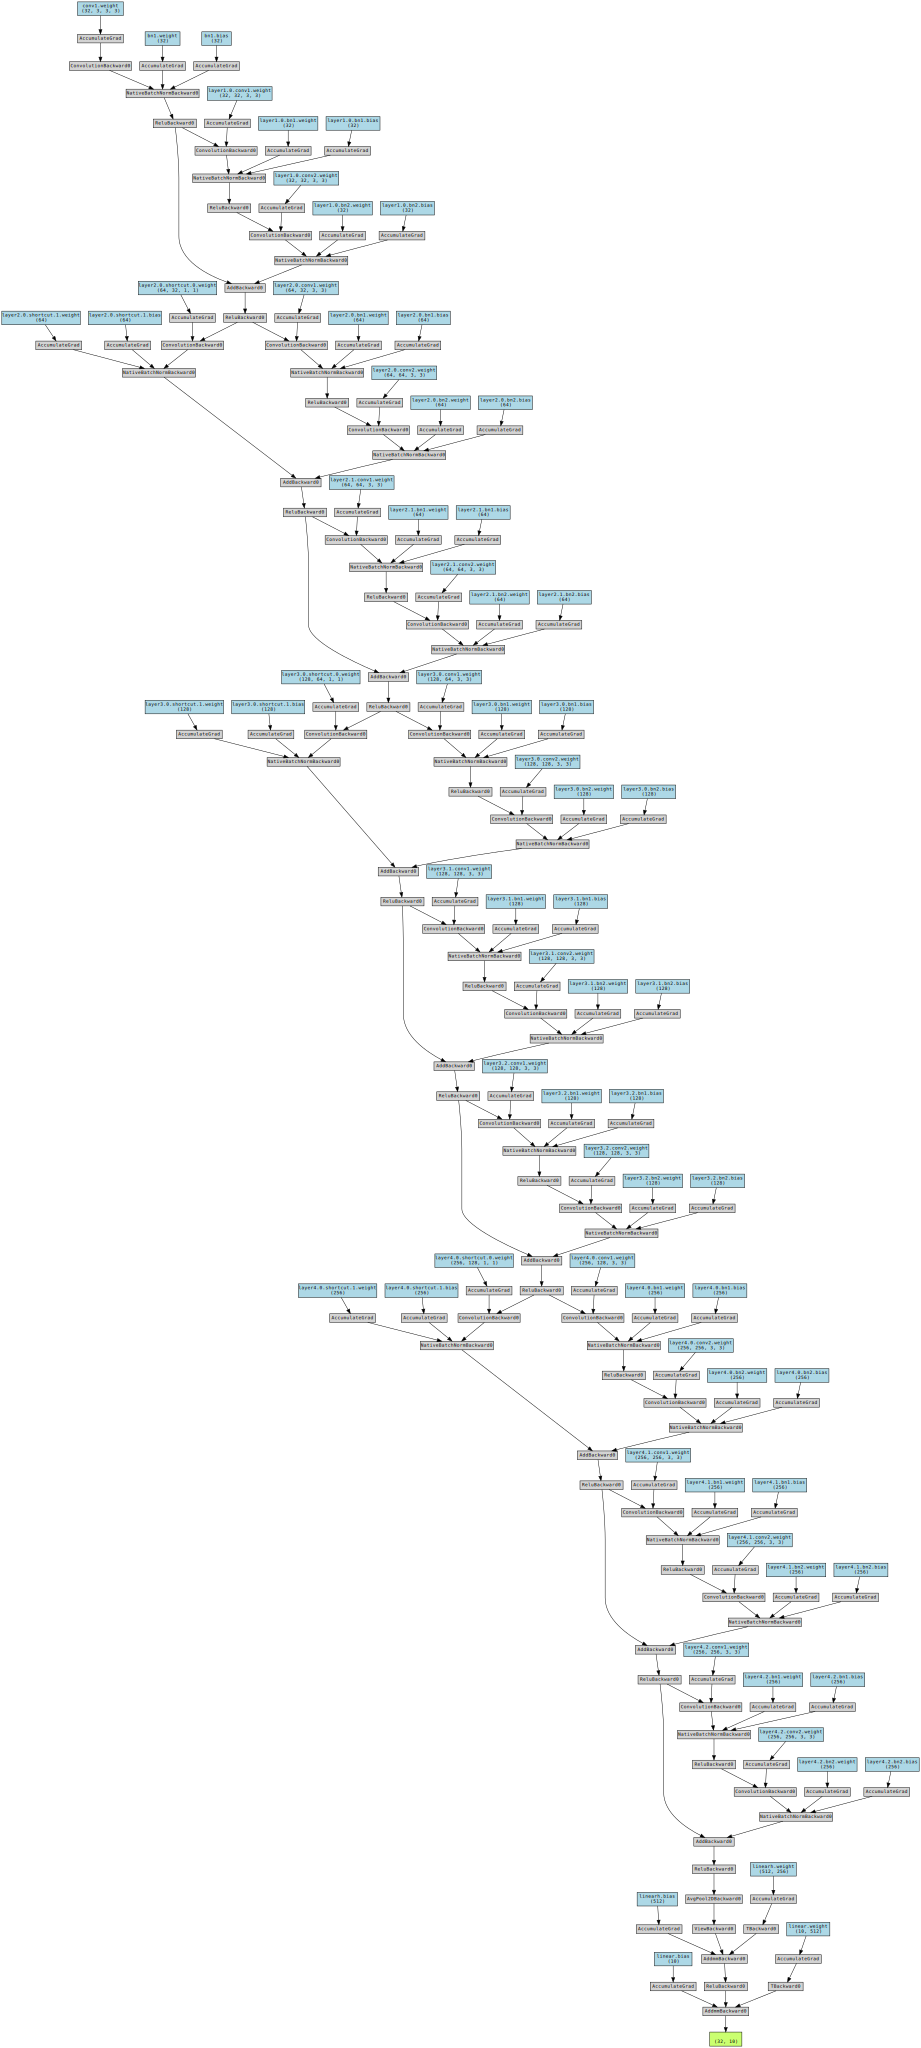

In [ ]:
#Figure for Architecture of the model
x = iter(trainloader)
images, label = x.__next__()
y = model(images)
make_dot(y, params=dict(model.named_parameters()))

In [ ]:
#Architecture of the model
from torchsummary import summary
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 16, 16]          18,432
       BatchNorm2d-9           [-1, 64, 16, 16]             128
           Conv2d-10           [-1, 64, 16, 16]          36,864
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]           2,048
      BatchNorm2d-13           [-1, 64, 16, 16]             128
       BasicBlock-14           [-1, 64,

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR


# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4) #Using the SGD optimizer
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) #Using Cosine Annealing LR for LR Scheduling
train_loss_history = []
train_accuracy = []
test_loss_history = []
test_accuracy = []

num_epoch = 100
for epoch in range(0, num_epoch):
    print('\nEpoch:', epoch+1)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)  #Finding the loss
        loss.backward()  #Backward propagation
        optimizer.step()

        train_loss += (loss.item())   #Calculating the total training loss in this batch
        _, predicted = outputs.max(1)    #Finding the predicted output
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()  #Calculating the accuracy
    train_accuracy.append(100.*correct/total)
    train_loss_history.append(train_loss)
    print('Train Loss: %.3f | Acc: %.3f%%'
          % (train_loss/(batch_idx+1), 100.*correct/total))
    
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += (loss.item())   #Calculating the total testing loss in this batch
            _, predicted = outputs.max(1)   #Finding the predicted output
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()  #Calculating the accuracy
        test_accuracy.append(100.*correct/total)
        test_loss_history.append(test_loss)
        print('Test Loss: %.3f | Acc: %.3f%%'
          % (test_loss/(batch_idx+1), 100.*correct/total))
    
     #Saving the best accruracy of the model
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc




Epoch: 1
Train Loss: 1.576 | Acc: 41.938%
Test Loss: 1.363 | Acc: 50.750%
Saving..

Epoch: 2
Train Loss: 1.096 | Acc: 61.134%
Test Loss: 1.064 | Acc: 64.140%
Saving..

Epoch: 3
Train Loss: 0.876 | Acc: 69.518%
Test Loss: 0.982 | Acc: 67.740%
Saving..

Epoch: 4
Train Loss: 0.741 | Acc: 74.166%
Test Loss: 0.813 | Acc: 73.150%
Saving..

Epoch: 5
Train Loss: 0.656 | Acc: 77.564%
Test Loss: 0.634 | Acc: 78.600%
Saving..

Epoch: 6
Train Loss: 0.593 | Acc: 79.684%
Test Loss: 0.602 | Acc: 79.820%
Saving..

Epoch: 7
Train Loss: 0.545 | Acc: 81.366%
Test Loss: 0.586 | Acc: 80.260%
Saving..

Epoch: 8
Train Loss: 0.509 | Acc: 82.604%
Test Loss: 0.493 | Acc: 83.230%
Saving..

Epoch: 9
Train Loss: 0.473 | Acc: 83.766%
Test Loss: 0.515 | Acc: 82.900%

Epoch: 10
Train Loss: 0.449 | Acc: 84.656%
Test Loss: 0.481 | Acc: 83.620%
Saving..

Epoch: 11
Train Loss: 0.431 | Acc: 85.142%
Test Loss: 0.460 | Acc: 84.800%
Saving..

Epoch: 12
Train Loss: 0.414 | Acc: 85.808%
Test Loss: 0.543 | Acc: 81.580%

Epoch:

In [ ]:
#print(train_loss_history)
#print(test_loss_history)

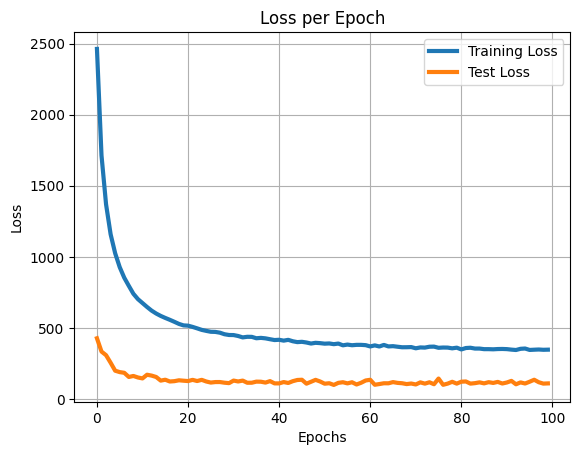

In [ ]:
import matplotlib.pyplot as plt

# Plot train loss
plt.plot(range(num_epoch), train_loss_history, '-', linewidth=3, label='Training Loss')
# Plot test loss
plt.plot(range(num_epoch), test_loss_history, '-', linewidth = 3, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

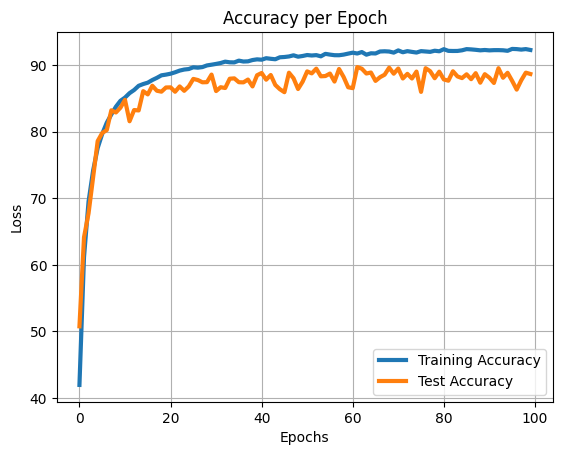

In [ ]:
# Plot train accuracy
plt.plot(range(num_epoch), train_accuracy, '-', linewidth=3, label='Training Accuracy')
# Plot test accuracy
plt.plot(range(num_epoch), test_accuracy, '-', linewidth = 3, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()